In [1]:
def normalize_array(arr):
    """Normalizes an array to have a range between 0 and 1"""
    min_val = np.min(arr)
    max_val = np.max(arr)
    return (arr - min_val) / (max_val - min_val)
"""
Here we implement all the BM25 variations mentioned. 
"""

from typing import List
from collections import defaultdict
import math
import numpy as np
from multiprocessing import Pool, cpu_count
#from textblob import TextBlob


class BM25:
    def __init__(self, corpus: List[str], tokenizer):
        self.corpus_size = 0
        self.avgdl = 0
        self.doc_freqs = []
        self.idf = {}
        self.doc_len = []
        self.tokenizer = tokenizer

        if tokenizer:
            corpus = self._tokenize_corpus(corpus)

        nd = self._initialize(corpus)
        self._calc_idf(nd)

    def _initialize(self, corpus):
        # word -> number of documents with word
        nd = defaultdict(int)
        num_doc = 0
        for document in corpus:
            self.doc_len.append(len(document))
            num_doc += len(document)

            frequencies = defaultdict(int)      # word: frequency
            for word in document:
                frequencies[word] += 1
            self.doc_freqs.append(frequencies)

            for word, _ in frequencies.items():
                nd[word] += 1
            self.corpus_size += 1

        self.avgdl = num_doc / self.corpus_size
        return nd

    def _tokenize_corpus(self, corpus):
        pool = Pool(cpu_count())
        tokenized_corpus = pool.map(self.tokenizer, corpus)
        return tokenized_corpus

    def _calc_idf(self, nd):
        raise NotImplementedError()

    
    def get_scores(self, query):
        raise NotImplementedError()
    def get_bm25scores(self, query):
        raise NotImplementedError()    

    def get_batch_scores(self, query, doc_ids):
        raise NotImplementedError()

    #initialise eval metric for variate models
    def eval_metric_func(self, query):
        raise NotImplementedError()

    def get_top_n(self, query:str, documents, n=5):
        assert self.corpus_size == len(
            documents
        ), "The documents given don't match the index corpus!"
        if self.tokenizer:
            query = self.tokenizer(query)
        scores = self.get_bm25scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n], scores[top_n]
    
    def get_top_var_n(self, query:str, documents, n=5):
        assert self.corpus_size == len(
            documents
        ), "The documents given don't match the index corpus!"
        if self.tokenizer:
            query = self.tokenizer(query)
        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n], scores[top_n]
    
    def eval_metr(self, score, l_score, n=10):
                    
            #normalise scores
        norm_score = normalize_array(score)
        norm_l_score = normalize_array(l_score)
        """
        #rev sort top_n l_score and store doc_id/index
        rev_norm_l_score = sorted(norm_l_score, reverse = True)
        top_n = n
        idx_list = []
        for i in range(top_n):
            idx_list.append(norm_l_score.get(rev_norm_l_score[i]))
        """
        #calc scores
        #relevance scoring can be 0,1,2,3; so we take 0.98 and above as reasonable for tp/fp ~98%
        ml_norm_score = [int(i>0.9995) for i in norm_score]
        ml_norm_l_score = [int(i>0.9995) for i in norm_l_score]

        tp = 0
        tn = 0
        fp = 0
        fn = 0
        for i in range(n):
            if ml_norm_l_score[i]==1 and ml_norm_score[i]==1:
                tp+=1
            if ml_norm_l_score[i]==0 and ml_norm_score[i]==0:
                tn+=1
            if ml_norm_l_score[i]==1 and ml_norm_score[i]==0:
                fp+=1
            if ml_norm_l_score[i]==0 and ml_norm_score[i]==1:
                fn+=1
        #metric set 1
        if tp+fp!=0:
            precision = tp/(tp+fp)
        else:
            precision = 0
        if tp+fn!=0:
            
            recall = tp/(tp+fn)
        else:
            recall = 0
        #accuracy = tp/(tp+fp+tn+fn)
        if  (2 * tp + fp + fn)!=0:
            
            f1 = 2 * tp / (2 * tp + fp + fn)
        else:
            f1 = 0
        #metric set 2
        
        ndcg = 0
        #ndcg
        dcg = l_score[0]
        for i in range(1, len(l_score)):
            dcg += l_score[i] / (np.log2(i + 1))
        idcg = score[0]
        for i in range(1, len(score)):
            idcg += score[i] / (np.log2(i + 1))

        # normalized discounted cumulative gain (NDCG) calculation
        if idcg == 0:
            ndcg = 0
        else:
            ndcg =  dcg / idcg
        
        
        return [precision, recall, f1, ndcg]
        
        
class BM25Okapi(BM25):
    def __init__(self, corpus, tokenizer=None, k1=1.5, b=0.75, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        super().__init__(corpus, tokenizer)

    def _calc_idf(self, nd):
        """
        Calculates frequencies of terms in documents and in corpus.
        This algorithm sets a floor on the idf values to eps * average_idf
        """
        # collect idf sum to calculate an average idf for epsilon value
        idf_sum = 0
        # collect words with negative idf to set them a special epsilon value.
        # idf can be negative if word is contained in more than half of documents
        negative_idfs = []
        for word, freq in nd.items():
            idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = idf_sum / len(self.idf)

        eps = self.epsilon * self.average_idf
        for word in negative_idfs:
            self.idf[word] = eps

    def get_bm25scores(self, query):
        """
        The ATIRE BM25 variant uses an idf function which uses a log(idf) score. To prevent negative idf scores,
        this algorithm also adds a floor to the idf value of epsilon.
        See [Trotman, A., X. Jia, M. Crane, Towards an Efficient and Effective Search Engine] for more info
        :param query:
        :return:
        """
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score
    def get_scores(self, query):
        """
        The ATIRE BM25 variant uses an idf function which uses a log(idf) score. To prevent negative idf scores,
        this algorithm also adds a floor to the idf value of epsilon.
        See [Trotman, A., X. Jia, M. Crane, Towards an Efficient and Effective Search Engine] for more info
        :param query:
        :return:
        """
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score.tolist()
"""
def get_sentiment(sentence):
    blob = TextBlob(sentence)

    # Sentiment from  -1 (negative) to 1 (positive)
    # Subjectivity: from 0 (objective) to 1 (subjective)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    return round(polarity, 2), round(subjectivity, 2)
"""



#new model bm25L for testing+eval metric function

class BM25L(BM25):
    def __init__(self, corpus, tokenizer=None, k1=1.5, b=0.75, delta=0.5):
        # Algorithm specific parameters
        self.k1 = k1
        self.b = b
        self.delta = delta
        super().__init__(corpus, tokenizer)

    def _calc_idf(self, nd):
        for word, freq in nd.items():
            idf = math.log(self.corpus_size + 1) - math.log(freq + 0.5)
            self.idf[word] = idf

    def get_scores(self, query):
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            ctd = q_freq / (1 - self.b + self.b * doc_len / self.avgdl)
            score += (self.idf.get(q) or 0) * (self.k1 + 1) * (ctd + self.delta) / \
                     (self.k1 + ctd + self.delta)
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            ctd = q_freq / (1 - self.b + self.b * doc_len / self.avgdl)
            score += (self.idf.get(q) or 0) * (self.k1 + 1) * (ctd + self.delta) / \
                     (self.k1 + ctd + self.delta)
        return score.tolist()

    def get_bm25scores(self, query):
        """
        The ATIRE BM25 variant uses an idf function which uses a log(idf) score. To prevent negative idf scores,
        this algorithm also adds a floor to the idf value of epsilon.
        See [Trotman, A., X. Jia, M. Crane, Towards an Efficient and Effective Search Engine] for more info
        :param query:
        :return:
        """
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score
 
class BM25Plus(BM25):
    def __init__(self, corpus, tokenizer=None, k1=1.5, b=0.75, delta=1):
        # Algorithm specific parameters
        self.k1 = k1
        self.b = b
        self.delta = delta
        super().__init__(corpus, tokenizer)

    def _calc_idf(self, nd):
        for word, freq in nd.items():
            idf = math.log((self.corpus_size + 1) / freq)
            self.idf[word] = idf

    def get_scores(self, query):
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (self.delta + (q_freq * (self.k1 + 1)) /
                                               (self.k1 * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (self.delta + (q_freq * (self.k1 + 1)) /
                                               (self.k1 * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
        return score.tolist()
    def get_bm25scores(self, query):
        """
        The ATIRE BM25 variant uses an idf function which uses a log(idf) score. To prevent negative idf scores,
        this algorithm also adds a floor to the idf value of epsilon.
        See [Trotman, A., X. Jia, M. Crane, Towards an Efficient and Effective Search Engine] for more info
        :param query:
        :return:
        """
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score

    #excluding bm25adpt, bm25t, bm11, bm15

In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
"""
Creates the Index and prepares index for the BM25 models
"""
import string
import pickle
from nltk.corpus import stopwords
import pandas as pd
import nltk
#from src.model import BM25Okapi
nltk.download('stopwords')
nltk.download('punkt')


stop_words = set(stopwords.words("english"))


def preprocess_text(text):
    """Preprocess text, used before indexing and query search
    """
    text = text.lower()  # convert to lowercase
    # remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # remove stop words
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text


def load(idxpath):
    """Loads the pickle file.
    """
    with open(idxpath, "rb") as idx_file:
        pkl_data = pickle.load(idx_file)
    return pkl_data['model'], pkl_data['data_index']


def create(fpath, idxpath):
    """ Creates index and returns the corpus dataframe
    """
    dataset_file = fpath
    col_names = ["doc_id", "category", "subcategory", "title",
                 "abstract", "url", "title_entities", "abstract_entities"]
    df_original = pd.read_csv(dataset_file, sep="\t",
                              header=None, names=col_names)
    print(f"Data dimensions: {df_original.shape}")

    # drop when df["title"] & df["abstract"] are nan
    df_no_nan = df_original.dropna(subset=["title", "abstract"])
    print(f"Data dimensions after removing nan: {df_no_nan.shape}")

    # preprocess the text
    df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
    df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)
    corpus = df_no_nan["preprocessed_text"].tolist()

    # Create and save index
    model = BM25Okapi(corpus, tokenizer=nltk.word_tokenize)
    pkl_data = {
        "model": model,
        "data_index": df_no_nan.index,
    }
    with open(idxpath, "wb") as idx_file:
        pickle.dump(pkl_data, idx_file)
    return df_original



def create_var_l(fpath, idxpath):
    """ Creates index and returns the corpus dataframe
    """
    dataset_file = fpath
    col_names = ["doc_id", "category", "subcategory", "title",
                 "abstract", "url", "title_entities", "abstract_entities"]
    df_original = pd.read_csv(dataset_file, sep="\t",
                              header=None, names=col_names)
    print(f"Data dimensions: {df_original.shape}")

    # drop when df["title"] & df["abstract"] are nan
    df_no_nan = df_original.dropna(subset=["title", "abstract"])
    print(f"Data dimensions after removing nan: {df_no_nan.shape}")

    # preprocess the text
    df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
    df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)
    corpus = df_no_nan["preprocessed_text"].tolist()

    # Create and save index
    model = BM25L(corpus, tokenizer=nltk.word_tokenize)
    pkl_data = {
        "model": model,
        "data_index": df_no_nan.index,
    }
    with open(idxpath, "wb") as idx_file:
        pickle.dump(pkl_data, idx_file)
    return df_original




[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:

def create_var_plus(fpath, idxpath):
    """ Creates index and returns the corpus dataframe
    """
    dataset_file = fpath
    col_names = ["doc_id", "category", "subcategory", "title",
                 "abstract", "url", "title_entities", "abstract_entities"]
    df_original = pd.read_csv(dataset_file, sep="\t",
                              header=None, names=col_names)
    print(f"Data dimensions: {df_original.shape}")

    # drop when df["title"] & df["abstract"] are nan
    df_no_nan = df_original.dropna(subset=["title", "abstract"])
    print(f"Data dimensions after removing nan: {df_no_nan.shape}")

    # preprocess the text
    df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
    df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)
    corpus = df_no_nan["preprocessed_text"].tolist()

    # Create and save index
    model = BM25Plus(corpus, tokenizer=nltk.word_tokenize)
    pkl_data = {
        "model": model,
        "data_index": df_no_nan.index,
    }
    with open(idxpath, "wb") as idx_file:
        pickle.dump(pkl_data, idx_file)
    return df_original


def create_var_11(fpath, idxpath):
    """ Creates index and returns the corpus dataframe
    """
    dataset_file = fpath
    col_names = ["doc_id", "category", "subcategory", "title",
                 "abstract", "url", "title_entities", "abstract_entities"]
    df_original = pd.read_csv(dataset_file, sep="\t",
                              header=None, names=col_names)
    print(f"Data dimensions: {df_original.shape}")

    # drop when df["title"] & df["abstract"] are nan
    df_no_nan = df_original.dropna(subset=["title", "abstract"])
    print(f"Data dimensions after removing nan: {df_no_nan.shape}")

    # preprocess the text
    df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
    df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)
    corpus = df_no_nan["preprocessed_text"].tolist()

    # Create and save index
    model = BM11(corpus, tokenizer=nltk.word_tokenize)
    pkl_data = {
        "model": model,
        "data_index": df_no_nan.index,
    }
    with open(idxpath, "wb") as idx_file:
        pickle.dump(pkl_data, idx_file)
    return df_original

def create_var_15(fpath, idxpath):
    """ Creates index and returns the corpus dataframe
    """
    dataset_file = fpath
    col_names = ["doc_id", "category", "subcategory", "title",
                 "abstract", "url", "title_entities", "abstract_entities"]
    df_original = pd.read_csv(dataset_file, sep="\t",
                              header=None, names=col_names)
    print(f"Data dimensions: {df_original.shape}")

    # drop when df["title"] & df["abstract"] are nan
    df_no_nan = df_original.dropna(subset=["title", "abstract"])
    print(f"Data dimensions after removing nan: {df_no_nan.shape}")

    # preprocess the text
    df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
    df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)
    corpus = df_no_nan["preprocessed_text"].tolist()

    # Create and save index
    model = BM15(corpus, tokenizer=nltk.word_tokenize)
    pkl_data = {
        "model": model,
        "data_index": df_no_nan.index,
    }
    with open(idxpath, "wb") as idx_file:
        pickle.dump(pkl_data, idx_file)
    return df_original

In [5]:
DATASET_PATH = "data/MINDsmall_train/news.tsv"
INDEX_PATH = "data/index/news.pickle"

model_variants = ['okapi', 'plus', 'l', '15', '11']

sample_queries = ['Gumgal', 'Google', 'It is cold out here in London', 'Ship Wreck', 
                  'The confluence of technological advancements in artificial intelligence, machine learning, and deep learning has enabled the development of sophisticated neural networks capable of performing complex tasks such as natural language processing, image recognition, and predictive modeling with high accuracy and precision.']
bm15_results = []
bm11_results = []
l_results = []
plus_results = []


for j in model_variants:
    for que in sample_queries:
        
        if j == 'okapi':
            df = create(DATASET_PATH, INDEX_PATH)
            model, data_index = load(INDEX_PATH)
            query = que
            processed_query = preprocess_text(query)
            results, scores = model.get_top_var_n(processed_query, data_index, n=10)
        
            
        if j == 'l':
            df = create_var_l(DATASET_PATH, INDEX_PATH)
            model, data_index = load(INDEX_PATH)
            query = que
            processed_query = preprocess_text(query)
            results, scores = model.get_top_var_n(processed_query, data_index, n=10)
            res2, base_scores = model.get_top_n(processed_query, data_index, n=10)
            
            print('BM25L Evaluation against BM25OKapi: ', model.eval_metr(normalize_array(base_scores), normalize_array(scores)))
            l_results.append(model.eval_metr(normalize_array(base_scores), normalize_array(scores)))

        if j == 'plus':
            df = create_var_plus(DATASET_PATH, INDEX_PATH)
            model, data_index = load(INDEX_PATH)
            query = que
            processed_query = preprocess_text(query)
            results, scores = model.get_top_var_n(processed_query, data_index, n=10)
            res2, base_scores = model.get_top_n(processed_query, data_index, n=10)
            
            print('BM25Plus Evaluation against BM25OKapi: ', model.eval_metr(normalize_array(base_scores), normalize_array(scores)))
            plus_results.append(model.eval_metr(normalize_array(base_scores), normalize_array(scores)))
    
    
    

Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/549525201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/549525201.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)
/tmp/ipykernel_7197/692976351.py:5: RuntimeWarning: invalid value encountered in true_divide
  return (arr - min_val) / (max_val - min_val)


BM25Plus Evaluation against BM25OKapi:  [0, 0, 0, nan]
Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/549525201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/549525201.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


BM25Plus Evaluation against BM25OKapi:  [1.0, 1.0, 1.0, 1.0000000000000018]
Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/549525201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/549525201.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


BM25Plus Evaluation against BM25OKapi:  [1.0, 1.0, 1.0, 0.9999999999999983]
Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/549525201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/549525201.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


BM25Plus Evaluation against BM25OKapi:  [1.0, 1.0, 1.0, 0.9999999999999999]
Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/549525201.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/549525201.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


BM25Plus Evaluation against BM25OKapi:  [1.0, 1.0, 1.0, 1.0000000000000027]
Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)
/tmp/ipykernel_7197/692976351.py:5: RuntimeWarning: invalid value encountered in true_divide
  return (arr - min_val) / (max_val - min_val)


BM25L Evaluation against BM25OKapi:  [0, 0, 0, nan]
Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


BM25L Evaluation against BM25OKapi:  [1.0, 1.0, 1.0, 0.996915548291025]
Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


BM25L Evaluation against BM25OKapi:  [1.0, 1.0, 1.0, 0.9952283427305206]
Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


BM25L Evaluation against BM25OKapi:  [1.0, 1.0, 1.0, 0.9776459560262621]
Data dimensions: (51282, 8)
Data dimensions after removing nan: (48616, 8)


/tmp/ipykernel_7197/1966928821.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["text"] = df_no_nan["title"] + " " + df_no_nan["abstract"]
/tmp/ipykernel_7197/1966928821.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nan["preprocessed_text"] = df_no_nan["text"].apply(preprocess_text)


BM25L Evaluation against BM25OKapi:  [1.0, 1.0, 1.0, 0.9396636640484911]


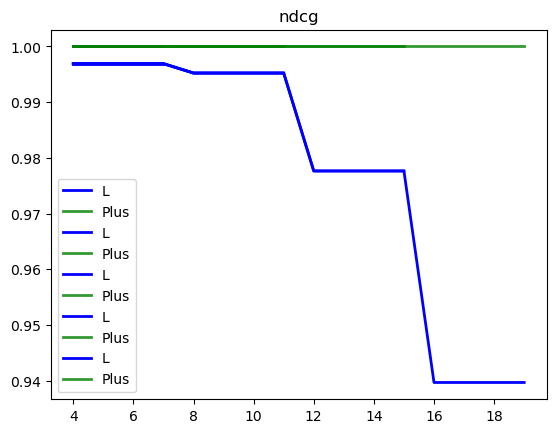

In [8]:
import matplotlib.pyplot as plt
l_st = []
plus_st = []
overlapping = 0.15
for i in range(len(l_results)):
        
        for j in range(4):
            
                #ndcg
            l_st.append(l_results[i][3])
            plus_st.append(plus_results[i][3])
            
        plt.plot(l_st, label = 'L', color = 'blue',  lw = 2)
        plt.plot(plus_st, label = 'Plus', color = 'green', alpha = 0.8, lw = 2)
        
        plt.title('ndcg')
plt.legend()
plt.show()

In [9]:
print(plus_st)
print(l_st)

[nan, nan, nan, nan, 1.0000000000000018, 1.0000000000000018, 1.0000000000000018, 1.0000000000000018, 0.9999999999999983, 0.9999999999999983, 0.9999999999999983, 0.9999999999999983, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 1.0000000000000027, 1.0000000000000027, 1.0000000000000027, 1.0000000000000027]
[nan, nan, nan, nan, 0.996915548291025, 0.996915548291025, 0.996915548291025, 0.996915548291025, 0.9952283427305206, 0.9952283427305206, 0.9952283427305206, 0.9952283427305206, 0.9776459560262621, 0.9776459560262621, 0.9776459560262621, 0.9776459560262621, 0.9396636640484911, 0.9396636640484911, 0.9396636640484911, 0.9396636640484911]


In [ ]:
"""

class BM25Adpt(BM25):
    def __init__(self, corpus, tokenizer = None, k1=1.5, b=0.75, delta=1):
      # Algorithm specific parameters
        self.k1 = k1
        self.b = b
        self.delta = delta
        super().__init__(corpus, tokenizer)
#
    def _calc_idf(self, nd):
        for word, freq in nd.items():
            idf = math.log((self.corpus_size + 1) / freq)
            self.idf[word] = idf
#
    def get_scores(self, query):
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (self.delta + (q_freq * (self.k1 + 1)) /
                                               (self.k1 * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
        return score
    def get_bm25scores(self, query):
        
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score
    
class BM25T(BM25):
    def __init__(self, corpus, tokenizer = None, k1=1.5, b=0.75, delta=1):
        self.k1 = k1
        self.b = b
        self.delta = delta
        super().__init__(corpus, tokenizer)
#
    def _calc_idf(self, nd):
        for word, freq in nd.items():
            idf = math.log((self.corpus_size + 1) / freq)
            self.idf[word] = idf
#
    def get_scores(self, query):
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (self.delta + (q_freq * (self.k1 + 1)) /
                                               (self.k1 * (1 - self.b + self.b * doc_len / self.avgdl) + q_freq))
        return score
    def get_bm25scores(self, query):
        
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score
"""
"""
   
class BM11(BM25):
    def __init__(self, corpus, tokenizer=None, k1=1.5, b=1, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        super().__init__(corpus, tokenizer)

    def _calc_idf(self, nd):
        
        # collect idf sum to calculate an average idf for epsilon value
        idf_sum = 0
        # collect words with negative idf to set them a special epsilon value.
        # idf can be negative if word is contained in more than half of documents
        negative_idfs = []
        for word, freq in nd.items():
            idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = idf_sum / len(self.idf)

        eps = self.epsilon * self.average_idf
        for word in negative_idfs:
            self.idf[word] = eps

    def get_bm25scores(self, query):
        
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score
    def get_scores(self, query):
        
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score

    def get_batch_scores(self, query, doc_ids):
        
        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score.tolist()
    
    
   
class BM15(BM25):
    def __init__(self, corpus, tokenizer=None, k1=1.5, b=0, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        super().__init__(corpus, tokenizer)

    def _calc_idf(self, nd):
        
        # collect idf sum to calculate an average idf for epsilon value
        idf_sum = 0
        # collect words with negative idf to set them a special epsilon value.
        # idf can be negative if word is contained in more than half of documents
        negative_idfs = []
        for word, freq in nd.items():
            idf = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = idf_sum / len(self.idf)

        eps = self.epsilon * self.average_idf
        for word in negative_idfs:
            self.idf[word] = eps

    def get_bm25scores(self, query):
        
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score
    def get_scores(self, query):
        
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)
        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score

    def get_batch_scores(self, query, doc_ids):
        
        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (
                q_freq
                * (self.k1 + 1)
                / (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl))
            )
        return score.tolist()
"""